<a href="https://colab.research.google.com/github/RitishaSood/PortfolioOptimization/blob/main/Portfolio_Optimization_ML_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Problem Statement**

# **2. Data Collection**

In [91]:
# Installing the required libraries
!pip install yfinance

In [92]:

# Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [93]:
# Fetching Data from yfinance
# Define the ticker symbols
tickers = ['AGG', 'VTI', 'DBC', '^VIX']  # Use '^VIX' for the volatility index

# Set the time period
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download OHLCV data
data = {}
for ticker in tickers:
    df = yf.download(ticker, start=start_date, end=end_date)
    df.to_csv(f"{ticker}_historical_OHLCV_data.csv")
    data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [94]:
# Displaying the AGG data
data['AGG'].head()

Price,Close,High,Low,Open,Volume
Ticker,AGG,AGG,AGG,AGG,AGG
Date,,,,,
2015-01-02,83.327904,83.380724,83.139260,83.139260,2090200
2015-01-05,83.509018,83.576933,83.365652,83.426014,3446200
2015-01-06,83.720314,84.022146,83.675041,83.727861,3688100
2015-01-07,83.705215,83.788219,83.561844,83.758036,3984400
2015-01-08,83.576958,83.637319,83.478859,83.637319,2212200


In [95]:
# Displaying the AGG data
data['DBC'].head()

Price,Close,High,Low,Open,Volume
Ticker,DBC,DBC,DBC,DBC,DBC
Date,,,,,
2015-01-02,15.931044,16.062127,15.887350,15.966000,1967300
2015-01-05,15.703833,15.861133,15.686356,15.861133,1827500
2015-01-06,15.555269,15.756266,15.511575,15.686354,1843100
2015-01-07,15.459145,15.607706,15.380494,15.537795,1868400
2015-01-08,15.520317,15.520317,15.363016,15.432928,1409400


In [96]:
# Displaying the AGG data
data['VTI'].head()

Price,Close,High,Low,Open,Volume
Ticker,VTI,VTI,VTI,VTI,VTI
Date,,,,,
2015-01-02,88.588005,89.257101,88.044365,89.064734,5298300
2015-01-05,87.065796,88.278532,86.865070,88.111255,5383500
2015-01-06,86.212723,87.400363,85.735994,87.316727,4226100
2015-01-07,87.241432,87.358523,86.605798,87.057430,3661500
2015-01-08,88.780357,88.855627,87.910535,87.994170,2796200


In [97]:
# Displaying the AGG data
data['^VIX'].head()

Price,Close,High,Low,Open,Volume
Ticker,^VIX,^VIX,^VIX,^VIX,^VIX
Date,,,,,
2015-01-02,17.790001,20.139999,17.049999,17.760000,0
2015-01-05,19.920000,21.290001,19.190001,19.190001,0
2015-01-06,21.120001,22.900000,19.520000,20.330000,0
2015-01-07,19.309999,20.719999,19.040001,20.150000,0
2015-01-08,17.010000,18.090000,16.990000,17.930000,0


# **3. Data Preprocessing**

In [98]:
# Reading all the CSV Files individually
agg = pd.read_csv("AGG_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vti = pd.read_csv("VTI_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
dbc = pd.read_csv("DBC_historical_OHLCV_data.csv", index_col=0, parse_dates=True)
vix = pd.read_csv("^VIX_historical_OHLCV_data.csv", index_col=0, parse_dates=True)

In [99]:
# Preprocessing Function for Each Asset
def preprocess_asset(df, asset_name):
    df = df.copy()

    # Convert relevant columns to numeric (errors='coerce' converts non-numeric to NaN)
    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in cols_to_convert:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Fill missing values
    df = df.ffill().bfill() # Forward & Backward filling

    # Sort by datetime
    df = df.sort_index()

    # Calculate features using 'Close'
    df['Daily Return'] = df['Close'].pct_change()
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['Rolling Volatility'] = df['Daily Return'].rolling(window=30).std() * np.sqrt(252)

    # Add prefix to all columns
    df = df.add_prefix(f'{asset_name}_')

    return df

In [100]:
# Apply Preprocessing to Each Asset
agg_clean = preprocess_asset(agg, 'AGG')
vti_clean = preprocess_asset(vti, 'VTI')
dbc_clean = preprocess_asset(dbc, 'DBC')
vix_clean = preprocess_asset(vix, 'VIX')

In [101]:
agg_clean.index.name = 'Date'
agg_clean.head()

,AGG_Close,AGG_High,AGG_Low,AGG_Open,AGG_Volume,AGG_Daily Return,AGG_Cumulative Return,AGG_MA10,AGG_MA50,AGG_Rolling Volatility
Date,,,,,,,,,,
2015-01-02,83.327904,83.380724,83.139260,83.139260,2090200.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,83.509018,83.576933,83.365652,83.426014,3446200.0,0.002174,1.002174,NaN,NaN,NaN
2015-01-06,83.720314,84.022146,83.675041,83.727861,3688100.0,0.002530,1.004709,NaN,NaN,NaN
2015-01-07,83.705215,83.788219,83.561844,83.758036,3984400.0,-0.000180,1.004528,NaN,NaN,NaN
2015-01-08,83.576958,83.637319,83.478859,83.637319,2212200.0,-0.001532,1.002989,NaN,NaN,NaN


In [102]:
vti_clean.index.name = 'Date'
vti_clean.head()

,VTI_Close,VTI_High,VTI_Low,VTI_Open,VTI_Volume,VTI_Daily Return,VTI_Cumulative Return,VTI_MA10,VTI_MA50,VTI_Rolling Volatility
Date,,,,,,,,,,
2015-01-02,88.588005,89.257101,88.044365,89.064734,5298300.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,87.065796,88.278532,86.865070,88.111255,5383500.0,-0.017183,0.982817,NaN,NaN,NaN
2015-01-06,86.212723,87.400363,85.735994,87.316727,4226100.0,-0.009798,0.973187,NaN,NaN,NaN
2015-01-07,87.241432,87.358523,86.605798,87.057430,3661500.0,0.011932,0.984800,NaN,NaN,NaN
2015-01-08,88.780357,88.855627,87.910535,87.994170,2796200.0,0.017640,1.002171,NaN,NaN,NaN


In [103]:
dbc_clean.index.name = 'Date'
dbc_clean.head()

,DBC_Close,DBC_High,DBC_Low,DBC_Open,DBC_Volume,DBC_Daily Return,DBC_Cumulative Return,DBC_MA10,DBC_MA50,DBC_Rolling Volatility
Date,,,,,,,,,,
2015-01-02,15.931044,16.062127,15.887350,15.966000,1967300.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,15.703833,15.861133,15.686356,15.861133,1827500.0,-0.014262,0.985738,NaN,NaN,NaN
2015-01-06,15.555269,15.756266,15.511575,15.686354,1843100.0,-0.009460,0.976412,NaN,NaN,NaN
2015-01-07,15.459145,15.607706,15.380494,15.537795,1868400.0,-0.006180,0.970379,NaN,NaN,NaN
2015-01-08,15.520317,15.520317,15.363016,15.432928,1409400.0,0.003957,0.974218,NaN,NaN,NaN


In [104]:
vix_clean.index.name = 'Date'
vix_clean.head()

,VIX_Close,VIX_High,VIX_Low,VIX_Open,VIX_Volume,VIX_Daily Return,VIX_Cumulative Return,VIX_MA10,VIX_MA50,VIX_Rolling Volatility
Date,,,,,,,,,,
2015-01-02,17.790001,20.139999,17.049999,17.760000,0.0,NaN,NaN,NaN,NaN,NaN
2015-01-05,19.920000,21.290001,19.190001,19.190001,0.0,0.119730,1.119730,NaN,NaN,NaN
2015-01-06,21.120001,22.900000,19.520000,20.330000,0.0,0.060241,1.187184,NaN,NaN,NaN
2015-01-07,19.309999,20.719999,19.040001,20.150000,0.0,-0.085701,1.085441,NaN,NaN,NaN
2015-01-08,17.010000,18.090000,16.990000,17.930000,0.0,-0.119109,0.956155,NaN,NaN,NaN


In [105]:
# Merge All Cleaned Data into One DataFrame
# Join on index (Date)
df_all = agg_clean.join([vti_clean, dbc_clean, vix_clean], how='inner')
df_all.dropna(inplace=True)  # Drop rows with incomplete feature sets

print(df_all.head())

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Date                                                                 
2015-03-16  83.712036  83.780166  83.590909  83.742318   1305800.0   
2015-03-17  83.696884  83.787729  83.681746  83.757448   1423700.0   
2015-03-18  84.310043  84.325181  83.711992  83.870967   1997800.0   
2015-03-19  84.014847  84.257095  83.984565  84.211670   1929700.0   
2015-03-20  84.272224  84.287362  84.166241  84.204095   3833600.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Date                                                                        
2015-03-16          0.002175               1.004610  83.496273  83.896126   
2015-03-17         -0.000181               1.004428  83.515201  83.903506   
2015-03-18          0.007326               1.011786  83.590900  83.919527   
2015-03-19         -0.003501               1.008244  83.633298  83.925417   
2015-03-20          0.003063               1.01

In [106]:
# Normalize or Scale for ML Models
from sklearn.preprocessing import StandardScaler

# Select only relevant features to scale (not raw prices)
features_to_scale = [
    col for col in df_all.columns
    if 'Daily Return' in col or 'Cumulative Return' in col or 'Volatility' in col
]

# Initialize scaler
scaler = StandardScaler()

# Scale only those features
scaled_subset = pd.DataFrame(
    scaler.fit_transform(df_all[features_to_scale]),
    columns=features_to_scale,
    index=df_all.index
)

# Merge back into original DataFrame (keeping unscaled features)
df_scaled = df_all.copy()
df_scaled[features_to_scale] = scaled_subset

# Preview
print(df_scaled.head())

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Date                                                                 
2015-03-16  83.712036  83.780166  83.590909  83.742318   1305800.0   
2015-03-17  83.696884  83.787729  83.681746  83.757448   1423700.0   
2015-03-18  84.310043  84.325181  83.711992  83.870967   1997800.0   
2015-03-19  84.014847  84.257095  83.984565  84.211670   1929700.0   
2015-03-20  84.272224  84.287362  84.166241  84.204095   3833600.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Date                                                                        
2015-03-16          0.523739              -1.336420  83.496273  83.896126   
2015-03-17         -0.045638              -1.338890  83.515201  83.903506   
2015-03-18          1.768501              -1.238942  83.590900  83.919527   
2015-03-19         -0.848031              -1.287060  83.633298  83.925417   
2015-03-20          0.738427              -1.24

In [107]:
# Saving the Normalized Data to a CSV File
df_scaled.to_csv("Normalized_Preprocessed_Combined_Data.csv")

print("Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'")

Final Normalized & Combined Data is saved to 'Normalized_Preprocessed_Combined_Data.csv'


# **4. EDA**

In [108]:
# Loading the final processed data
df = pd.read_csv("Normalized_Preprocessed_Combined_Data.csv", index_col=0, parse_dates=True)

# Preview data
print(df.head())

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Date                                                                 
2015-03-16  83.712036  83.780166  83.590909  83.742318   1305800.0   
2015-03-17  83.696884  83.787729  83.681746  83.757448   1423700.0   
2015-03-18  84.310043  84.325181  83.711992  83.870967   1997800.0   
2015-03-19  84.014847  84.257095  83.984565  84.211670   1929700.0   
2015-03-20  84.272224  84.287362  84.166241  84.204095   3833600.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Date                                                                        
2015-03-16          0.523739              -1.336420  83.496273  83.896126   
2015-03-17         -0.045638              -1.338890  83.515201  83.903506   
2015-03-18          1.768501              -1.238942  83.590900  83.919527   
2015-03-19         -0.848031              -1.287060  83.633298  83.925417   
2015-03-20          0.738427              -1.24

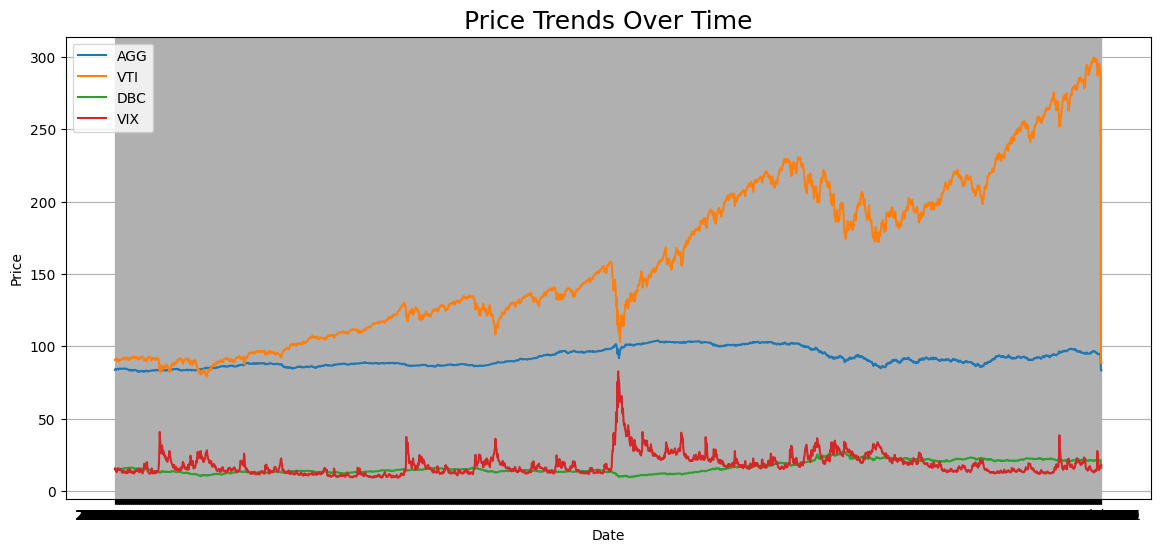

In [109]:
# Plotting the Price Trends Over Time
plt.figure(figsize=(14, 6))

for asset in ['AGG', 'VTI', 'DBC', 'VIX']:
    plt.plot(df[f'{asset}_Close'], label=asset)

plt.title("Price Trends Over Time", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

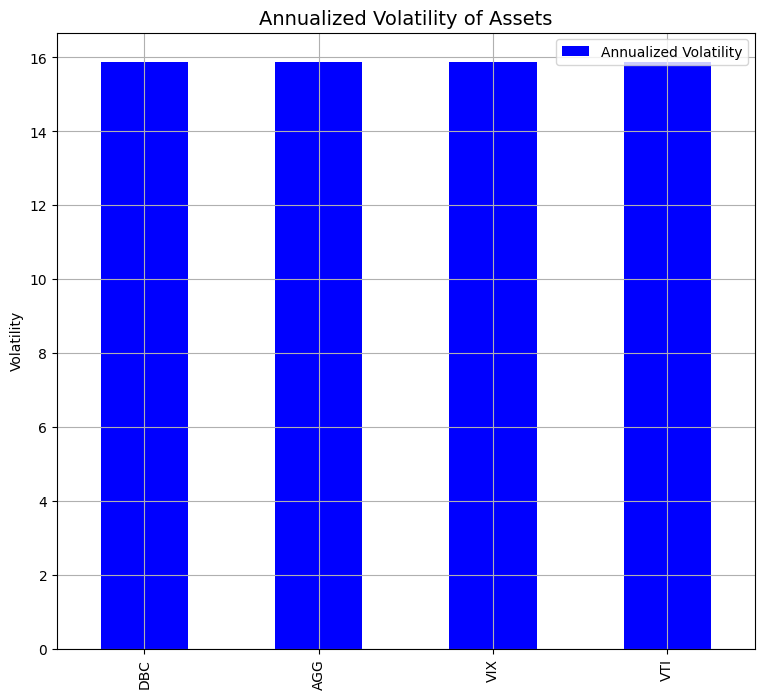

In [110]:
# Plotting the Volatility (Standard Deviation of Daily Returns)
volatility = {
    asset: df[f'{asset}_Daily Return'].std() * np.sqrt(252)  # annualized
    for asset in ['AGG', 'VTI', 'DBC', 'VIX']
}

vol_df = pd.DataFrame.from_dict(volatility, orient='index', columns=['Annualized Volatility'])
vol_df.sort_values('Annualized Volatility', ascending=False).plot(kind='bar', figsize=(9, 8), color='blue')
plt.title("Annualized Volatility of Assets", fontsize=14)
plt.ylabel("Volatility")
plt.grid(True)
plt.show()

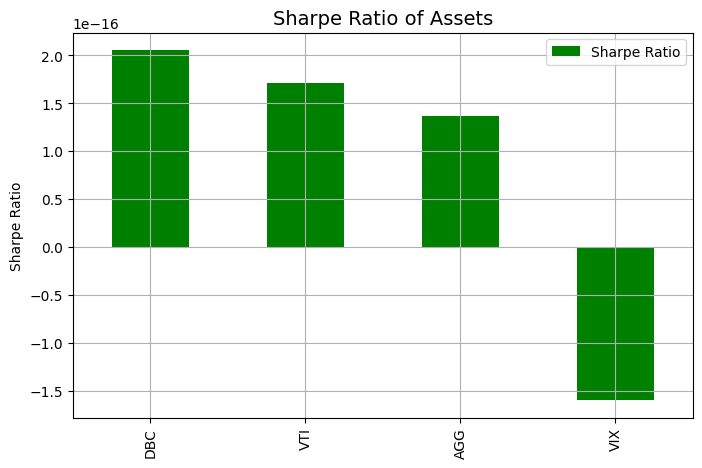

In [111]:
# Plotting the Sharpe Ratio
sharpe_ratios = {
    asset: df[f'{asset}_Daily Return'].mean() / df[f'{asset}_Daily Return'].std() * np.sqrt(252)
    for asset in ['AGG', 'VTI', 'DBC', 'VIX']
}

sharpe_df = pd.DataFrame.from_dict(sharpe_ratios, orient='index', columns=['Sharpe Ratio'])
sharpe_df.sort_values('Sharpe Ratio', ascending=False).plot(kind='bar', figsize=(8, 5), color='green')
plt.title("Sharpe Ratio of Assets", fontsize=14)
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.show()


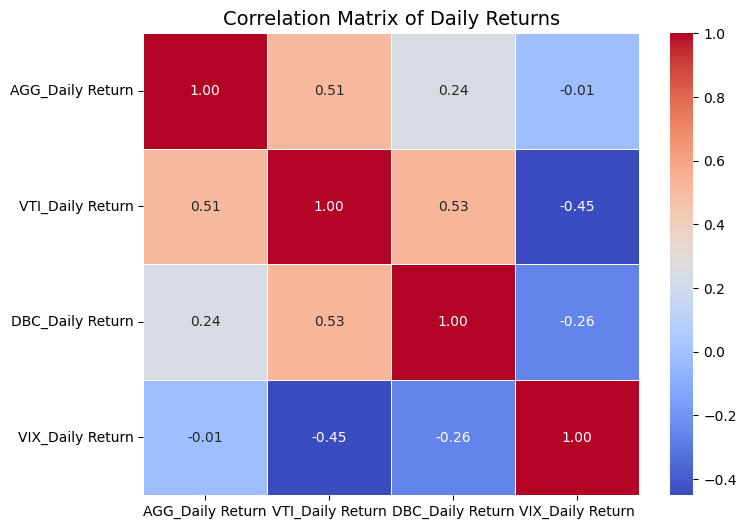

In [112]:
# Plotting the Correlation Matrix (Daily Returns)
returns_df = df[[f'{asset}_Daily Return' for asset in ['AGG', 'VTI', 'DBC', 'VIX']]]
corr = returns_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Daily Returns", fontsize=14)
plt.show()

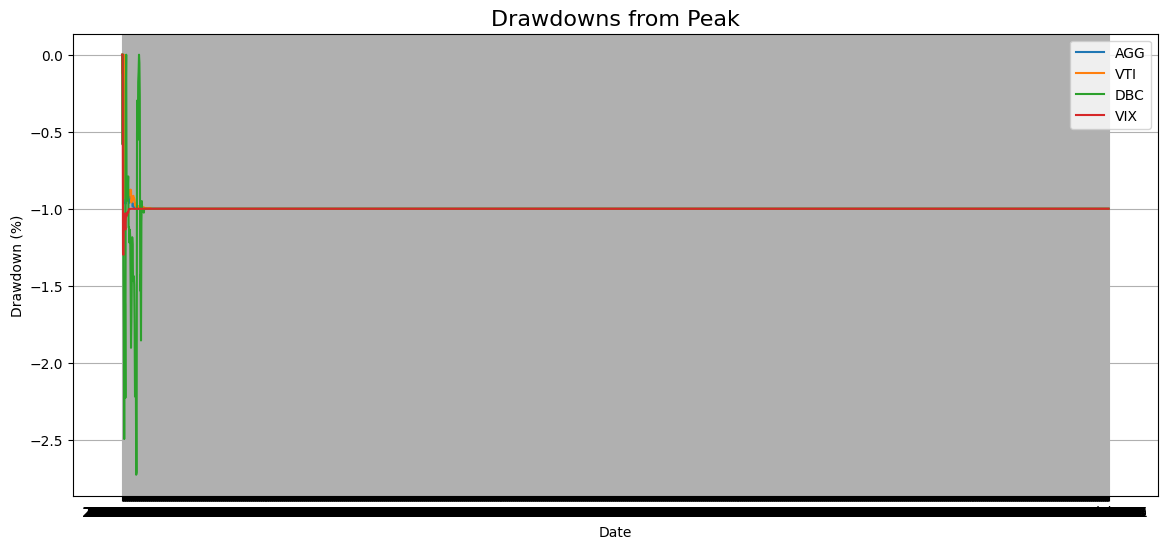

In [113]:
# Plotting the Drawdown (Max Loss from Peak)
def calculate_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown

plt.figure(figsize=(14, 6))
for asset in ['AGG', 'VTI', 'DBC', 'VIX']:
    drawdown = calculate_drawdown(df[f'{asset}_Daily Return'])
    plt.plot(drawdown, label=asset)
plt.title("Drawdowns from Peak", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.legend()
plt.grid(True)
plt.show()


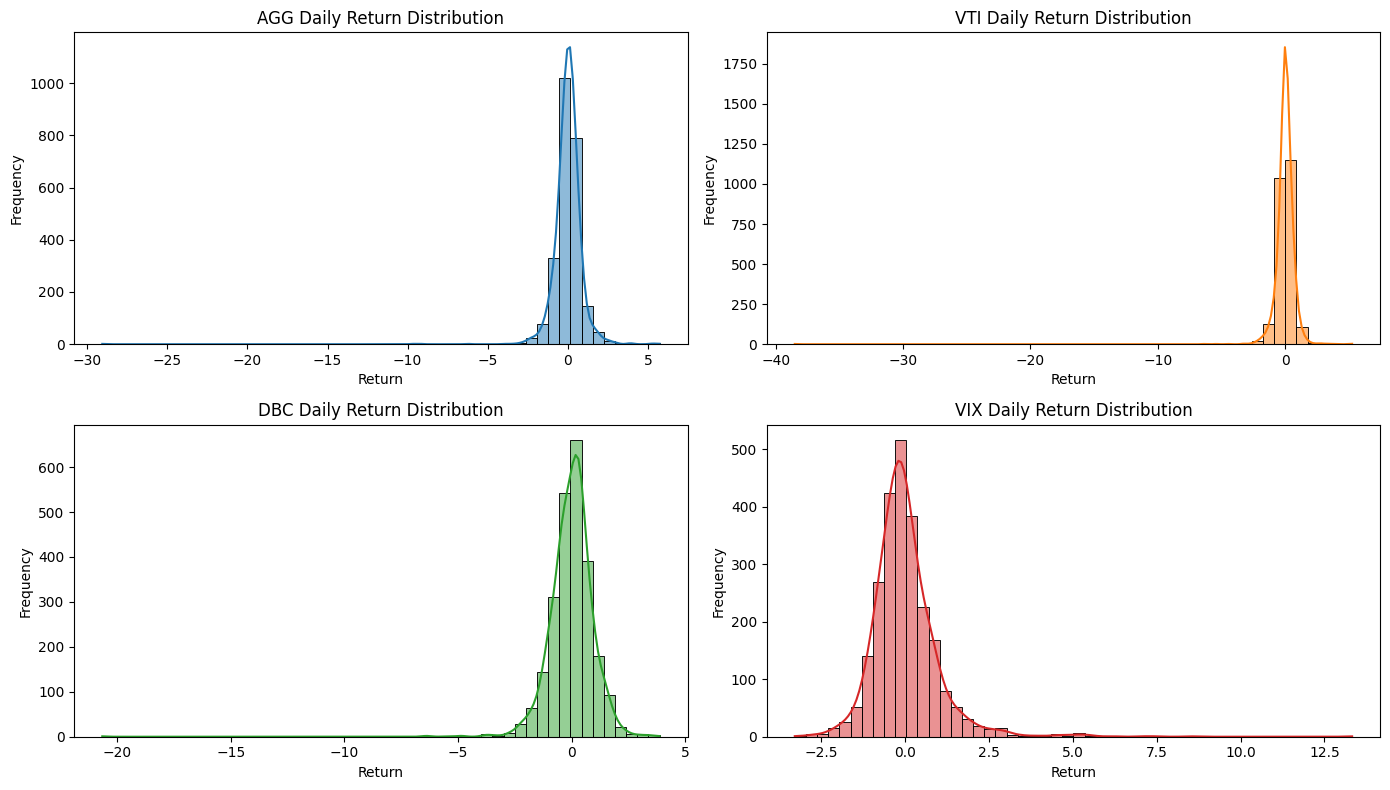

In [114]:
# Plotting the Histograms of Return Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()
assets = ['AGG', 'VTI', 'DBC', 'VIX']

for i, asset in enumerate(assets):
    sns.histplot(df[f'{asset}_Daily Return'], bins=50, kde=True, ax=axes[i], color=sns.color_palette()[i])
    axes[i].set_title(f"{asset} Daily Return Distribution", fontsize=12)
    axes[i].set_xlabel("Return")
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# **5. Feature Engineering**

RSI stands for Relative Strength Index. It’s a popular technical indicator used to measure momentum — specifically whether an asset is overbought or oversold.

📉 Formula (simplified):

RSI = 100 − [100 / (1 + (Avg Gain / Avg Loss))]
Usually calculated over 14 days.

✅ Why Are We Computing RSI?

If RSI > 70 → the asset is likely overbought (price may fall)

If RSI < 30 → the asset is likely oversold (price may rise)

📌 It helps the model understand reversal zones and trend strength, which is useful for:

ML: better classification of “buy/sell/hold” periods
DL: learning price movement patterns
Portfolio Optimization: avoid allocating to overheated assets

In short: RSI adds “emotional context” to price data.

In [115]:
# Function to compute RSI
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [116]:
# Function to compute Z-score of returns
def compute_return_zscore(series, window=21):
    mean = series.rolling(window).mean()
    std = series.rolling(window).std()
    return (series - mean) / std

In [117]:
# Function to compute Drawdown
def compute_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    return (cumulative - peak) / peak

In [118]:
# Function to add all the advanced features
def add_advanced_features(df):
    assets = ['AGG', 'DBC', 'VIX', 'VTI']

    for asset in assets:
        close = df[f'{asset}_Close']

        df[f'{asset}_RSI'] = compute_RSI(close)
        df[f'{asset}_Return_ZScore'] = compute_return_zscore(close.pct_change())
        df[f'{asset}_Drawdown'] = compute_drawdown(close.pct_change())

    return df

In [119]:
# Implementing the function above in the combined dataset - df :
df = add_advanced_features(df)

print(df)

            AGG_Close   AGG_High    AGG_Low   AGG_Open  AGG_Volume  \
Date                                                                 
2015-03-16  83.712036  83.780166  83.590909  83.742318   1305800.0   
2015-03-17  83.696884  83.787729  83.681746  83.757448   1423700.0   
2015-03-18  84.310043  84.325181  83.711992  83.870967   1997800.0   
2015-03-19  84.014847  84.257095  83.984565  84.211670   1929700.0   
2015-03-20  84.272224  84.287362  84.166241  84.204095   3833600.0   
...               ...        ...        ...        ...         ...   
2024-12-27  94.462685  94.707052  94.433362  94.609307   8601300.0   
2024-12-30  94.834129  94.892783  94.775484  94.814583  10154500.0   
2024-12-31  94.716835  95.019848  94.648412  94.961202  12276700.0   
Date        83.327904  83.380724  83.139260  83.139260   2090200.0   
Ticker      83.327904  83.380724  83.139260  83.139260   2090200.0   

            AGG_Daily Return  AGG_Cumulative Return   AGG_MA10   AGG_MA50  \
Date        

In [120]:
# Calculate Mean Returns and Covariance Matrix
# Get daily returns only
returns = df[[f'{asset}_Daily Return' for asset in ['AGG', 'VTI', 'DBC', 'VIX']]]

# Drop NaNs if RSI introduced them
returns.dropna(inplace=True)

# Mean returns (annualized)
mean_returns = returns.mean() * 252

# Covariance matrix (annualized)
cov_matrix = returns.cov() * 252

print("Mean Returns:\n", mean_returns)
print("\nCovariance Matrix:\n", cov_matrix)

Mean Returns:
 AGG_Daily Return    2.175659e-15
VTI_Daily Return    2.719574e-15
DBC_Daily Return    3.263489e-15
VIX_Daily Return   -2.538269e-15
dtype: float64

Covariance Matrix:
                   AGG_Daily Return  VTI_Daily Return  DBC_Daily Return  \
AGG_Daily Return        252.102107        128.249897         61.329654   
VTI_Daily Return        128.249897        252.102107        132.394234   
DBC_Daily Return         61.329654        132.394234        252.102107   
VIX_Daily Return         -3.760524       -113.523789        -65.864067   

                  VIX_Daily Return  
AGG_Daily Return         -3.760524  
VTI_Daily Return       -113.523789  
DBC_Daily Return        -65.864067  
VIX_Daily Return        252.102107  


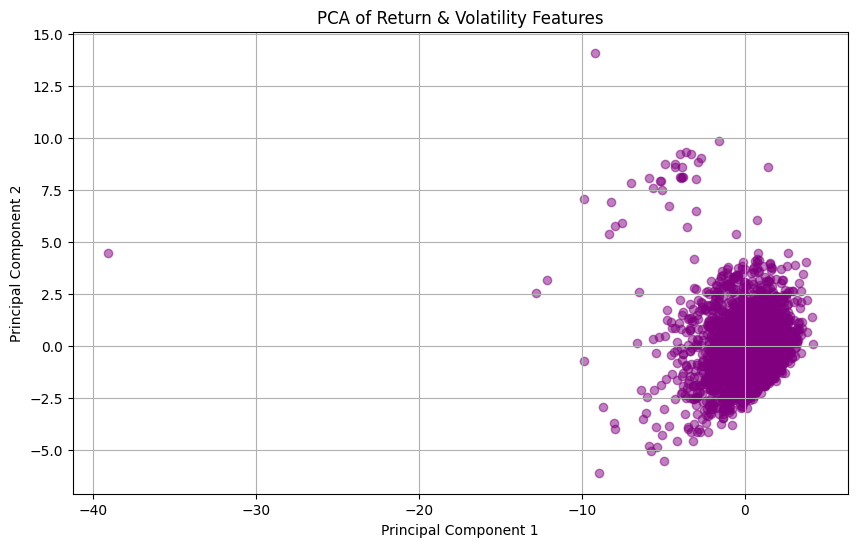

In [121]:
# Adding PCA :
from sklearn.decomposition import PCA

# Keep only return/volatility-based features for PCA
features_for_pca = df[[col for col in df.columns if 'Return' in col or 'Volatility' in col]]
features_for_pca.dropna(inplace=True)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_for_pca)

# Create DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=features_for_pca.index)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='purple', alpha=0.5)
plt.title("PCA of Return & Volatility Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# **6. Portfolio Optimization**

In [122]:
!pip install pandas yfinance PyPortfolioOpt


In [123]:

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier




In [124]:
df.head()

,AGG_Close,AGG_High,AGG_Low,AGG_Open,AGG_Volume,AGG_Daily Return,AGG_Cumulative Return,AGG_MA10,AGG_MA50,AGG_Rolling Volatility,...,AGG_Drawdown,DBC_RSI,DBC_Return_ZScore,DBC_Drawdown,VIX_RSI,VIX_Return_ZScore,VIX_Drawdown,VTI_RSI,VTI_Return_ZScore,VTI_Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
2015-03-16,83.712036,83.780166,83.590909,83.742318,1305800.0,0.523739,-1.336420,83.496273,83.896126,-0.063855,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-17,83.696884,83.787729,83.681746,83.757448,1423700.0,-0.045638,-1.338890,83.515201,83.903506,-0.064167,...,0.000000,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,0.00000
2015-03-18,84.310043,84.325181,83.711992,83.870967,1997800.0,1.768501,-1.238942,83.590900,83.919527,0.077630,...,0.000000,NaN,NaN,0.000000,NaN,NaN,-0.107918,NaN,NaN,0.00000
2015-03-19,84.014847,84.257095,83.984565,84.211670,1929700.0,-0.848031,-1.287060,83.633298,83.925417,0.103348,...,-0.003501,NaN,NaN,-0.016792,NaN,NaN,-0.101533,NaN,NaN,-0.00357
2015-03-20,84.272224,84.287362,84.166241,84.204095,3833600.0,0.738427,-1.245106,83.755935,83.936757,0.123062,...,-0.000449,NaN,NaN,-0.003474,NaN,NaN,-0.168582,NaN,NaN,0.00000


In [125]:
# df should be your DataFrame of asset prices with dates as index
price_df = df[[f'{asset}_Close' for asset in ['AGG', 'VTI', 'DBC', 'VIX']]]
price_df.dropna(inplace=True)
mu = mean_historical_return(price_df)                       # Annualized mean returns
S = CovarianceShrinkage(price_df).ledoit_wolf()



In [126]:
# Step 2: Optimize Portfolio
#Maximize Sharpe Ratio
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()


In [127]:
# Step 3: Compute Portfolio Metrics
expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance(verbose=True)


Expected annual return: 0.1%
Annual volatility: 9.8%
Sharpe Ratio: 0.01


In [128]:
#Step 4: Output Results
print("Optimal Weights:\n", cleaned_weights)
print(f"Expected Return: {expected_annual_return:.2%}")
print(f"Volatility: {annual_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Optimal Weights:
 OrderedDict([('AGG_Close', 0.80882), ('VTI_Close', 0.0), ('DBC_Close', 0.1788), ('VIX_Close', 0.01238)])
Expected Return: 0.11%
Volatility: 9.83%
Sharpe Ratio: 0.01


# **7. Machine Learning**

# **8. Deep Learning for Trend Prediction**